# Turquake: Turkish Earthquake Pattern Analysis & Risk Assessment

This notebook applies unsupervised learning to discover natural earthquake patterns and assess seismic risk across Turkey. We'll use enhanced geological features to identify risk zones and evaluate city-specific vulnerabilities.

**Key Objectives:**
- Discover earthquake clusters using K-Means and DBSCAN
- Identify high-risk seismic zones through pattern analysis
- Assess earthquake risk for major Turkish cities
- Create comprehensive risk maps for emergency planning

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap, MarkerCluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.graph_objects as go
import joblib
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import geopandas as gpd
from shapely.geometry import Point, LineString
import math
import os

# Set visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Load the enhanced earthquake dataset
try:
    earthquake_df = pd.read_csv('produced_data/enhanced_earthquake_data.csv')
    print("Loaded enhanced earthquake dataset")
except FileNotFoundError:
    print("Enhanced dataset not found, loading clean data...")
    earthquake_df = pd.read_csv('produced_data/clean_earthquake_data.csv')

# Load fault line data
fault_gdf = gpd.read_file('data\\tr_faults_imp.geojson')
print(f"Number of fault lines: {len(fault_gdf)}")
print(f"Available properties: {fault_gdf.columns.tolist()}")

# Verify coordinate range
print(f"Dataset shape: {earthquake_df.shape}")
print(f"Coordinate ranges:")
print(f"Longitude: {earthquake_df['Longitude'].min():.2f} to {earthquake_df['Longitude'].max():.2f}")
print(f"Latitude: {earthquake_df['Latitude'].min():.2f} to {earthquake_df['Latitude'].max():.2f}")

earthquake_df.head()

Loaded enhanced earthquake dataset
Number of fault lines: 926
Available properties: ['fid', 'RATE', 'CONF', 'SENS1', 'SENS2', 'UPSIDE', 'ZONE_NAME', 'FAULT_NAME', 'AUTH', 'PARM', 'TEXT', 'FAULT_ID', 'importance', 'geometry']
Dataset shape: (9829, 84)
Coordinate ranges:
Longitude: 25.00 to 45.00
Latitude: 35.00 to 42.79


,Date,Longitude,Latitude,Depth,Type,Magnitude,Location,EventID,TimeName,TypeName,...,seasonal_location_lat,seasonal_location_lon,multi_fault_complexity,distance_to_fault,nearest_fault_importance,poly_Depth weighted_fault_risk,poly_Depth fault_complexity_score,poly_weighted_fault_risk fault_complexity_score,magnitude_fault_interaction,weighted_magnitude_interaction
0,1900-01-18 15:30:00,28.21,37.79,10.0,MS,4.4,-,7697,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,18.895000,24.430577,1.618724,3.911122,6.0,185.682236,29.436050,54.657516,0.895926,81.700184
1,1900-01-24 03:00:00,26.14,39.54,10.0,MS,5.2,-,7698,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,19.770000,22.637904,0.282280,9.556012,4.0,64.654353,30.312057,19.598064,0.492610,33.620264
2,1900-01-27 02:30:00,37.37,37.63,10.0,MS,4.8,-,7699,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,18.815000,32.363369,0.763644,1.831552,1.0,149.081654,20.682598,30.833959,1.695183,71.559194
3,1900-01-30 01:00:00,27.71,37.83,10.0,MS,4.4,-,7700,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,18.915000,23.997564,1.547789,5.622901,4.0,170.596698,24.676285,42.096927,0.664361,75.062547
4,1900-02-06 15:09:00,31.29,38.12,10.0,MS,5.7,-,7701,Ambraseys-Finkel 1987,Ambraseys-Finkel 1987,...,33.012888,15.645000,0.141725,15.331402,6.0,75.391225,19.794919,14.923632,0.349021,42.972998


## Enhanced Data Preparation for Clustering

Preparing our earthquake dataset for clustering analysis using enhanced geological features. We load the enhanced dataset from supervised learning or create basic fault features if unavailable, ensuring compatibility across different data scenarios.

**Enhanced Features Used:**
- Multi-fault weighted risk scores
- Spatial density at multiple scales  
- Fault complexity measurements
- Geographic and temporal patterns

In [2]:
# Enhanced data preparation for clustering
def calc_fault_distance(row, fault_gdf):
    """Calculate basic fault distance if enhanced features not available"""
    point = Point(row['Longitude'], row['Latitude'])
    
    distances = []
    for idx, fault in fault_gdf.iterrows():
        fault_geom = fault.geometry
        dist = point.distance(fault_geom)
        distances.append((dist, idx))
    
    closest_dist, closest_idx = min(distances, key=lambda x: x[0])
    dist_km = closest_dist * 111
    closest_fault = fault_gdf.iloc[closest_idx]
    
    return pd.Series({
        'distance_to_fault': dist_km,
        'nearest_fault_name': closest_fault.get('FAULT_NAME', 'Unknown'),
        'nearest_fault_importance': closest_fault.get('importance', 0)
    })

# Check for enhanced features, add basic ones if missing
enhanced_features = ['weighted_fault_risk', 'fault_complexity_score', 'density_50km', 'fault_count_100km']
missing_features = [f for f in enhanced_features if f not in earthquake_df.columns]

if missing_features:
    print(f"Missing enhanced features: {missing_features}")
    print("Adding basic fault features...")
    
    # Add basic fault features if not present
    if 'distance_to_fault' not in earthquake_df.columns:
        basic_fault_features = earthquake_df.apply(lambda row: calc_fault_distance(row, fault_gdf), axis=1)
        earthquake_df = pd.concat([earthquake_df, basic_fault_features], axis=1)

# Enhanced clustering features selection
base_features = ['Longitude', 'Latitude', 'Depth', 'Magnitude']
fault_features = ['distance_to_fault', 'nearest_fault_importance']

# Add enhanced features if available
enhanced_clustering_features = []
if 'weighted_fault_risk' in earthquake_df.columns:
    enhanced_clustering_features.extend(['weighted_fault_risk', 'fault_complexity_score'])
if 'density_50km' in earthquake_df.columns:
    enhanced_clustering_features.extend(['density_50km', 'density_100km'])
if 'fault_count_100km' in earthquake_df.columns:
    enhanced_clustering_features.append('fault_count_100km')

# Final clustering features
clustering_features = base_features + fault_features + enhanced_clustering_features

print(f"Enhanced clustering features: {clustering_features}")

# Create a subset of data for clustering
cluster_data = earthquake_df[clustering_features].copy()

# Check for missing values
print("Missing values in clustering features:")
print(cluster_data.isnull().sum())

# Fill any missing values if needed
cluster_data.fillna(cluster_data.median(), inplace=True)

# Enhanced standardization with feature scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)
scaled_df = pd.DataFrame(scaled_data, columns=clustering_features)

print("Enhanced data prepared for clustering:")
print(f"Features used: {len(clustering_features)}")
scaled_df.describe()

# Create directories if they don't exist
os.makedirs("maps", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("produced_data", exist_ok=True)

print("Created output directories: maps, models, produced_data")

Enhanced clustering features: ['Longitude', 'Latitude', 'Depth', 'Magnitude', 'distance_to_fault', 'nearest_fault_importance', 'weighted_fault_risk', 'fault_complexity_score', 'density_50km', 'density_100km', 'fault_count_100km']
Missing values in clustering features:
Longitude                   0
Latitude                    0
Depth                       0
Magnitude                   0
distance_to_fault           0
nearest_fault_importance    0
weighted_fault_risk         0
fault_complexity_score      0
density_50km                0
density_100km               0
fault_count_100km           0
dtype: int64
Enhanced data prepared for clustering:
Features used: 11
Created output directories: maps, models, produced_data


## Enhanced K-Means Clustering Analysis

Implementing K-Means clustering with enhanced geological features to identify natural earthquake groupings. We determine optimal cluster numbers using both elbow method and silhouette analysis.

**Clustering Strategy:**
- Enhanced feature set for better geological representation
- Systematic evaluation of cluster numbers (2-11)
- Statistical validation of cluster quality

K=2, Inertia=84259.97, Silhouette Score=0.245
K=3, Inertia=74329.94, Silhouette Score=0.182
K=4, Inertia=67082.31, Silhouette Score=0.188
K=5, Inertia=61545.47, Silhouette Score=0.193
K=6, Inertia=56418.53, Silhouette Score=0.194
K=7, Inertia=51675.15, Silhouette Score=0.205
K=8, Inertia=48918.70, Silhouette Score=0.207
K=9, Inertia=46801.80, Silhouette Score=0.207
K=10, Inertia=44824.37, Silhouette Score=0.190
K=11, Inertia=43037.40, Silhouette Score=0.190


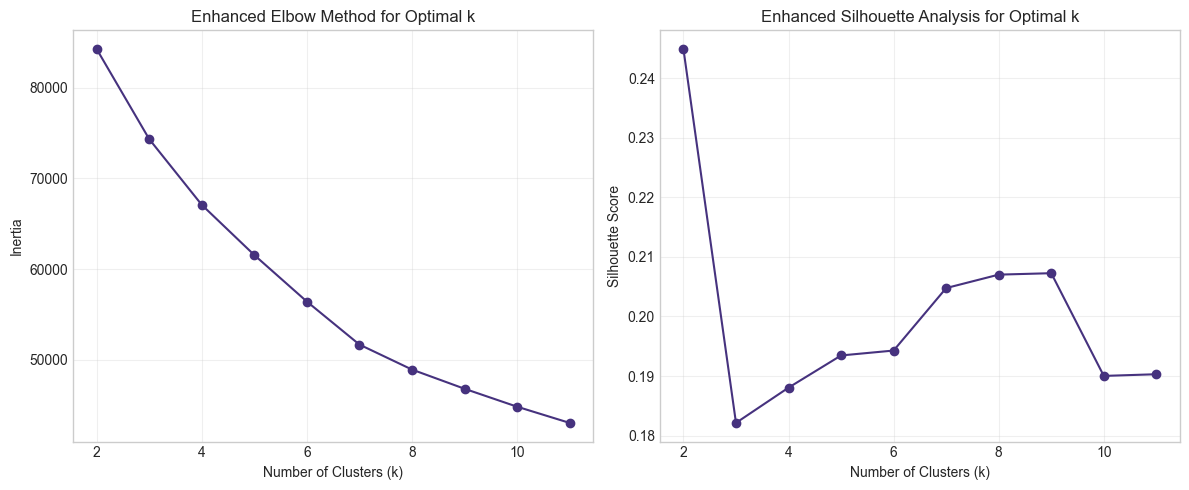

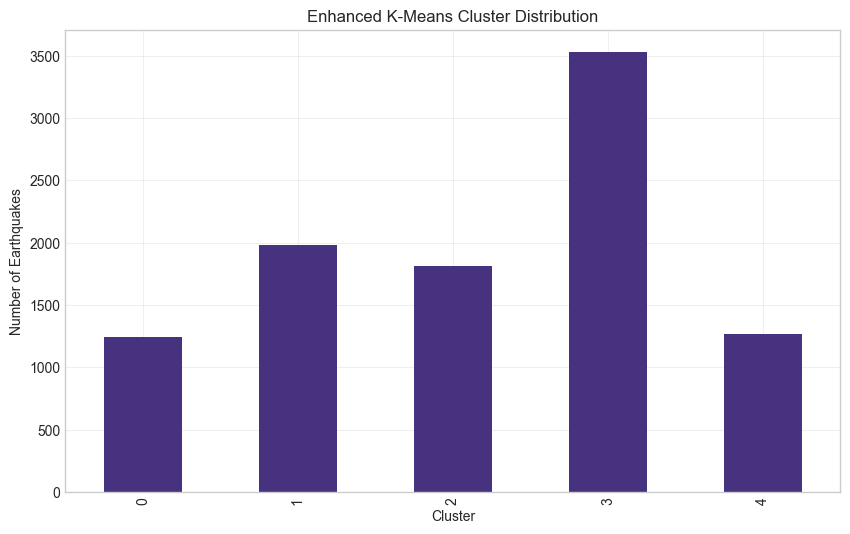

Enhanced K-Means clustering completed with 5 clusters
Cluster distribution:
KMeans_Cluster
0    1242
1    1979
2    1811
3    3532
4    1265
Name: count, dtype: int64


In [3]:
# Enhanced K-Means clustering with more features
inertia = []
silhouette_scores = []
k_range = range(2, 12)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(scaled_data, labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"K={k}, Inertia={kmeans.inertia_:.2f}, Silhouette Score={silhouette_avg:.3f}")

# Plot enhanced elbow method results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Enhanced Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Enhanced Silhouette Analysis for Optimal k')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Select optimal k
optimal_k = 5

# Apply enhanced K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the original dataframe
earthquake_df['KMeans_Cluster'] = cluster_labels

# Enhanced cluster distribution analysis
plt.figure(figsize=(10, 6))
cluster_counts = earthquake_df['KMeans_Cluster'].value_counts().sort_index()
cluster_counts.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Earthquakes')
plt.title('Enhanced K-Means Cluster Distribution')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Enhanced K-Means clustering completed with {optimal_k} clusters")
print(f"Cluster distribution:\n{cluster_counts}")

## Enhanced K-Means Visualization and Analysis

Creating comprehensive visualizations of our K-Means clusters including detailed cluster characteristics analysis. Enhanced popups show fault risk, complexity scores, and spatial density metrics.

**Cluster Analysis:**
- Geographic distribution patterns
- Cluster-specific geological characteristics  
- Enhanced fault relationship analysis
- Interactive maps with detailed feature information

In [4]:
# Enhanced cluster characteristics analysis
cluster_analysis = earthquake_df.groupby('KMeans_Cluster').agg({
    'Longitude': 'mean',
    'Latitude': 'mean',
    'Depth': 'mean',
    'Magnitude': 'mean',
    'KMeans_Cluster': 'count'
}).rename(columns={'KMeans_Cluster': 'Count'})

# Add enhanced fault distance stats if available
if 'distance_to_fault' in earthquake_df.columns:
    fault_stats = earthquake_df.groupby('KMeans_Cluster').agg({
        'distance_to_fault': ['mean', 'min'],
        'nearest_fault_importance': 'mean'
    })
    fault_stats.columns = ['_'.join(col).strip() for col in fault_stats.columns.values]
    cluster_analysis = pd.concat([cluster_analysis, fault_stats], axis=1)

# Add enhanced features stats if available
enhanced_stats = {}
if 'weighted_fault_risk' in earthquake_df.columns:
    enhanced_stats['weighted_fault_risk'] = earthquake_df.groupby('KMeans_Cluster')['weighted_fault_risk'].mean()
if 'fault_complexity_score' in earthquake_df.columns:
    enhanced_stats['fault_complexity_score'] = earthquake_df.groupby('KMeans_Cluster')['fault_complexity_score'].mean()
if 'density_50km' in earthquake_df.columns:
    enhanced_stats['density_50km'] = earthquake_df.groupby('KMeans_Cluster')['density_50km'].mean()

for feature, values in enhanced_stats.items():
    cluster_analysis[feature] = values

print("Enhanced cluster characteristics:")
print(cluster_analysis.round(3))

# Create enhanced K-means map visualization
kmeans_map = folium.Map(location=[38.5, 35.5], zoom_start=6)

# Enhanced cluster colors
cluster_colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'darkblue', 'cadetblue']

# Add enhanced clusters as markers
for idx, row in earthquake_df.iterrows():
    cluster_idx = int(row['KMeans_Cluster']) % len(cluster_colors)
    color = cluster_colors[cluster_idx]
    
    # Enhanced radius calculation
    if row['Magnitude'] >= 7:
        radius = 15 + ((row['Magnitude'] - 7) ** 2) * 6
    else:
        radius = 3 + (row['Magnitude'] - 4) ** 1.5
    
    # Enhanced popup with new features
    popup_content = f"""
    <b>Cluster:</b> {row['KMeans_Cluster']}<br>
    <b>Magnitude:</b> {row['Magnitude']:.1f}<br>
    <b>Depth:</b> {row['Depth']:.1f} km<br>
    """
    
    if 'weighted_fault_risk' in row:
        popup_content += f"<b>Fault Risk:</b> {row['weighted_fault_risk']:.2f}<br>"
    if 'fault_complexity_score' in row:
        popup_content += f"<b>Complexity:</b> {row['fault_complexity_score']:.2f}<br>"
    if 'density_50km' in row:
        popup_content += f"<b>Density (50km):</b> {row['density_50km']:.3f}<br>"
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_content, max_width=300)
    ).add_to(kmeans_map)

# Add enhanced cluster centers
for cluster_id, group in earthquake_df.groupby('KMeans_Cluster'):
    center_lat = group['Latitude'].mean()
    center_lon = group['Longitude'].mean()
    cluster_idx = int(cluster_id) % len(cluster_colors)
    color = cluster_colors[cluster_idx]
    
    folium.CircleMarker(
        location=[center_lat, center_lon],
        radius=8,
        color='black',
        fill=True,
        fill_color=color,
        fill_opacity=0.9,
        popup=f"Enhanced Cluster Center {cluster_id}"
    ).add_to(kmeans_map)

# Add fault lines
def add_faults_to_map(map_obj, fault_gdf, importance_threshold=0):
    if importance_threshold > 0:
        fault_data = fault_gdf[fault_gdf['importance'] >= importance_threshold]
    else:
        fault_data = fault_gdf
    
    def style_function(feature):
        importance = feature['properties']['importance']
        color = '#FF0000' if importance >= 4 else '#FFA500' if importance >= 3 else '#FFFF00'
        return {
            'color': color,
            'weight': importance * 0.5,
            'opacity': 0.7
        }
    
    folium.GeoJson(
        fault_data,
        name='Fault Lines',
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(fields=['FAULT_NAME', 'importance']),
    ).add_to(map_obj)
    
    return map_obj

# Add enhanced fault lines
kmeans_map = add_faults_to_map(kmeans_map, fault_gdf, importance_threshold=3)

# Add enhanced legend
kmeans_legend_html = '''
<div style="position: fixed; bottom: 50px; right: 50px; width: 200px; 
    background-color: white; border:2px solid grey; z-index:9999; 
    padding: 10px; border-radius: 5px; font-family: Arial;">
    <h4 style="margin-top:0;">Enhanced K-Means Clusters</h4>
    <div style="margin-top:5px;">
      <p><b>Cluster Colors:</b></p>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: red; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Cluster 0</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: blue; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Cluster 1</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: green; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Cluster 2</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: purple; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Cluster 3</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: orange; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Cluster 4</span>
      </div>
    </div>
    <div style="margin-top:10px;">
      <p><b>Enhanced Features:</b> Fault risk, complexity, density</p>
    </div>
</div>
'''
kmeans_map.get_root().html.add_child(folium.Element(kmeans_legend_html))

folium.LayerControl().add_to(kmeans_map)
kmeans_map.save('maps/enhanced_kmeans_clusters_map.html')
print("Enhanced K-means cluster map saved")

Enhanced cluster characteristics:
                Longitude  Latitude   Depth  Magnitude  Count  \
KMeans_Cluster                                                  
0                  28.753    36.021  26.040      4.419   1242   
1                  39.584    38.507  15.658      4.432   1979   
2                  38.729    40.010  16.509      4.534   1811   
3                  28.837    38.557  17.227      4.426   3532   
4                  27.292    36.046  34.951      4.423   1265   

                distance_to_fault_mean  distance_to_fault_min  \
KMeans_Cluster                                                  
0                              147.583                 23.205   
1                                6.762                  0.002   
2                               39.581                  0.015   
3                               15.761                  0.002   
4                               76.862                  1.970   

                nearest_fault_importance_mean  weighte

## Enhanced 3D K-Means Visualization

Generating interactive 3D visualizations that reveal the spatial structure of earthquake clusters in longitude-latitude-depth space. Enhanced hover data includes all geological features for comprehensive exploration.

In [ ]:
# Create enhanced 3D scatter plot of KMeans clusters
hover_data = ['Depth', 'Magnitude', 'KMeans_Cluster']
if 'weighted_fault_risk' in earthquake_df.columns:
    hover_data.extend(['weighted_fault_risk', 'fault_complexity_score'])
if 'density_50km' in earthquake_df.columns:
    hover_data.extend(['density_50km'])

fig = px.scatter_3d(
    earthquake_df, 
    x='Longitude', 
    y='Latitude', 
    z='Depth',
    color='KMeans_Cluster', 
    size='Magnitude',
    color_continuous_scale=px.colors.qualitative.Bold,
    hover_data=hover_data,
    title='Enhanced 3D K-Means Earthquake Clusters'
)

# Enhanced axis configuration
fig.update_layout(scene=dict(
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    zaxis_title='Depth (km)',
    zaxis=dict(autorange="reversed")
))

fig.write_html('maps/enhanced_kmeans_clusters_3d.html')
print("Enhanced 3D KMeans visualization saved")

# Enhanced plotly version for interactive viewing
fig_kmeans = px.scatter_mapbox(
    earthquake_df, 
    lat='Latitude',
    lon='Longitude',
    color='KMeans_Cluster',
    size='Magnitude',
    color_continuous_scale=px.colors.qualitative.Bold,
    size_max=15,
    zoom=5,
    center={"lat": 38.5, "lon": 35.5},
    mapbox_style="open-street-map",
    title='Enhanced K-Means Clusters Interactive Map',
    hover_data=hover_data
)
fig_kmeans.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig_kmeans.write_html('maps/enhanced_kmeans_interactive.html')
print("Enhanced interactive KMeans map saved")

Enhanced 3D KMeans visualization saved
Enhanced interactive KMeans map saved


## Enhanced DBSCAN Clustering

Applying DBSCAN (Density-Based Spatial Clustering) with enhanced features to identify density-based earthquake patterns. DBSCAN excels at finding irregular cluster shapes and identifying noise points.

**DBSCAN Advantages:**
- Identifies clusters of arbitrary shapes
- Automatically determines cluster numbers
- Detects outlier/noise earthquakes
- Handles varying density patterns

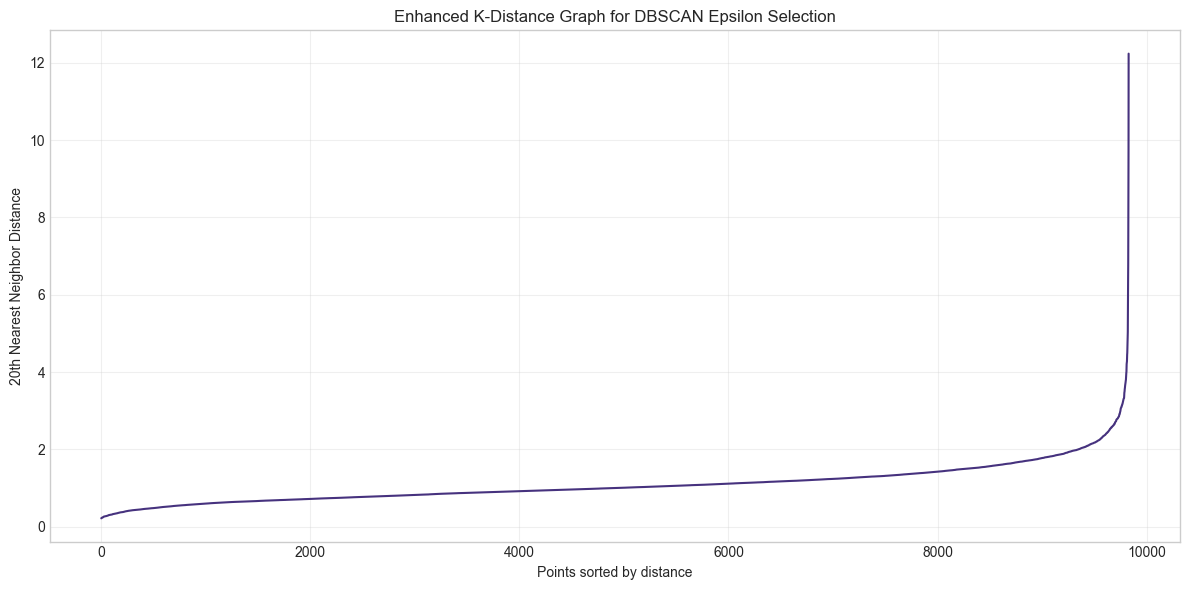

Enhanced DBSCAN found 15 clusters and 8330 noise points.
Noise percentage: 84.75%


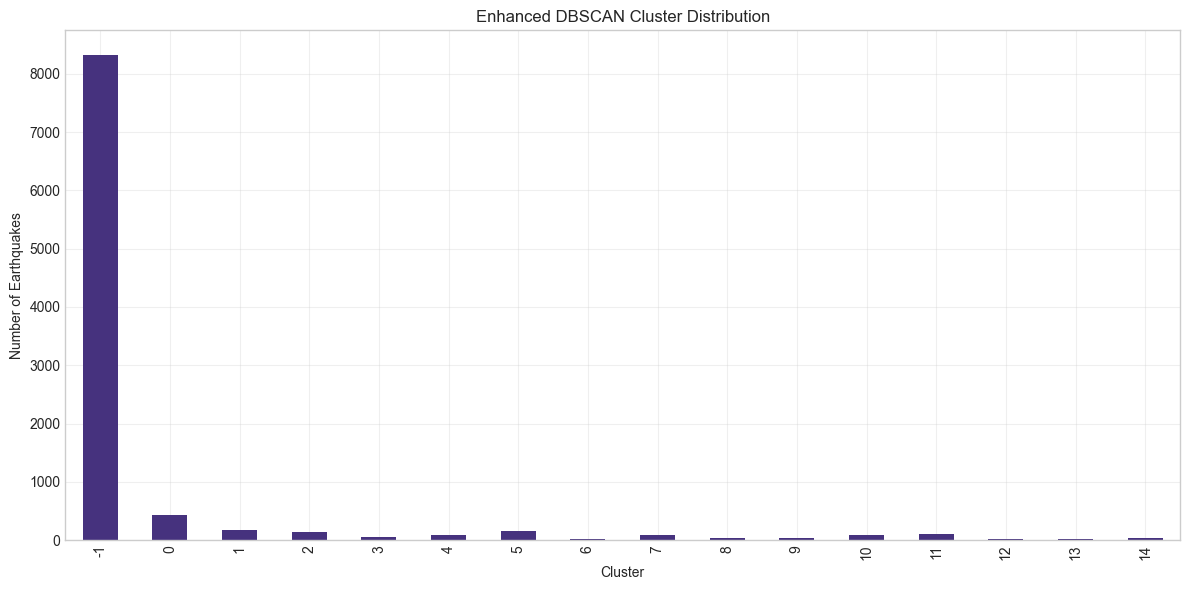

Enhanced DBSCAN completed with 15 clusters


In [6]:
# Enhanced DBSCAN clustering with more dimensions
from sklearn.neighbors import NearestNeighbors

# Determine epsilon using k-distance graph for enhanced features
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

distances = np.sort(distances, axis=0)
distances = distances[:, 19]  # 20th neighbor

plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('20th Nearest Neighbor Distance')
plt.title('Enhanced K-Distance Graph for DBSCAN Epsilon Selection')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Adjusted parameters for enhanced features
epsilon = 0.6  # Adjusted for higher dimensionality
min_samples = 25

# Apply enhanced DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(scaled_data)

earthquake_df['DBSCAN_Cluster'] = dbscan_labels

# Enhanced DBSCAN analysis
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Enhanced DBSCAN found {n_clusters} clusters and {n_noise} noise points.")
print(f"Noise percentage: {n_noise / len(dbscan_labels) * 100:.2f}%")

# Enhanced cluster distribution visualization
plt.figure(figsize=(12, 6))
cluster_counts = earthquake_df['DBSCAN_Cluster'].value_counts().sort_index()
cluster_counts.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Earthquakes')
plt.title('Enhanced DBSCAN Cluster Distribution')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Enhanced DBSCAN completed with {n_clusters} clusters")

## Enhanced DBSCAN Visualization and Analysis

Creating comprehensive DBSCAN visualizations with enhanced geological context. We analyze both cluster characteristics and noise point patterns to understand spatial earthquake distribution.

**Analysis Components:**
- Cluster distribution and characteristics
- Noise point analysis with enhanced features
- Geographic pattern visualization
- Enhanced popup information

In [7]:
# Enhanced DBSCAN map visualization
dbscan_map = folium.Map(location=[38.5, 35.5], zoom_start=6)

num_clusters = len(set(earthquake_df['DBSCAN_Cluster'])) - (1 if -1 in earthquake_df['DBSCAN_Cluster'].values else 0)
colormap = cm.get_cmap('tab20', max(num_clusters + 1, 2))

def get_cluster_color(cluster_id):
    if cluster_id == -1:
        return '#000000'  # Noise points
    else:
        rgba = colormap(cluster_id % max(num_clusters, 1))
        return mcolors.rgb2hex(rgba)

# Add enhanced data points
for idx, row in earthquake_df.iterrows():
    cluster_id = int(row['DBSCAN_Cluster'])
    color = get_cluster_color(cluster_id)
    
    if row['Magnitude'] >= 7:
        radius = 15 + ((row['Magnitude'] - 7) ** 2) * 6
    else:
        radius = 3 + (row['Magnitude'] - 4) ** 1.5
    
    # Enhanced popup content
    popup_content = f"""
    <b>Cluster:</b> {cluster_id}<br>
    <b>Magnitude:</b> {row['Magnitude']:.1f}<br>
    <b>Depth:</b> {row['Depth']:.1f} km<br>
    """
    
    if 'weighted_fault_risk' in row:
        popup_content += f"<b>Fault Risk:</b> {row['weighted_fault_risk']:.2f}<br>"
    if 'density_50km' in row:
        popup_content += f"<b>Density:</b> {row['density_50km']:.3f}<br>"
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7 if cluster_id != -1 else 0.3,
        popup=folium.Popup(popup_content, max_width=300)
    ).add_to(dbscan_map)

dbscan_map = add_faults_to_map(dbscan_map, fault_gdf, importance_threshold=3)

# Enhanced DBSCAN legend
dbscan_legend_html = '''
<div style="position: fixed; bottom: 50px; right: 50px; width: 200px; 
    background-color: white; border:2px solid grey; z-index:9999; 
    padding: 10px; border-radius: 5px; font-family: Arial;">
    <h4 style="margin-top:0;">Enhanced DBSCAN Clusters</h4>
    <div style="margin-top:5px;">
      <p><b>Each color = spatial cluster</b></p>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: black; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%; opacity: 0.3;"></div>
        <span>Noise points (-1)</span>
      </div>
    </div>
    <div style="margin-top:10px;">
      <p><b>Enhanced with:</b> Fault risk, complexity, density features</p>
    </div>
</div>
'''
dbscan_map.get_root().html.add_child(folium.Element(dbscan_legend_html))

folium.LayerControl().add_to(dbscan_map)
dbscan_map.save('maps/enhanced_dbscan_clusters_map.html')

# Enhanced cluster analysis (excluding noise)
dbscan_analysis = earthquake_df[earthquake_df['DBSCAN_Cluster'] != -1].groupby('DBSCAN_Cluster').agg({
    'Longitude': 'mean',
    'Latitude': 'mean',
    'Depth': 'mean',
    'Magnitude': 'mean',
    'DBSCAN_Cluster': 'count'
}).rename(columns={'DBSCAN_Cluster': 'Count'})

# Add enhanced features to analysis
if 'weighted_fault_risk' in earthquake_df.columns:
    enhanced_dbscan = earthquake_df[earthquake_df['DBSCAN_Cluster'] != -1].groupby('DBSCAN_Cluster').agg({
        'weighted_fault_risk': 'mean',
        'fault_complexity_score': 'mean'
    })
    dbscan_analysis = pd.concat([dbscan_analysis, enhanced_dbscan], axis=1)

print("Enhanced DBSCAN cluster characteristics:")
print(dbscan_analysis.round(3))

# Enhanced noise point analysis
noise_points = earthquake_df[earthquake_df['DBSCAN_Cluster'] == -1]
print(f"\nEnhanced noise point analysis ({len(noise_points)} points):")
noise_cols = ['Magnitude', 'Depth']
if 'weighted_fault_risk' in noise_points.columns:
    noise_cols.extend(['weighted_fault_risk', 'density_50km'])
print(noise_points[noise_cols].describe().round(3))

C:\Users\Sarp Can\AppData\Local\Temp\ipykernel_8376\3346068464.py:5: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Enhanced DBSCAN cluster characteristics:
                Longitude  Latitude   Depth  Magnitude  Count  \
DBSCAN_Cluster                                                  
0                  27.042    38.701  10.062      4.145    436   
1                  25.560    36.582   7.748      4.340    168   
2                  27.155    36.286   9.970      4.143    140   
3                  26.897    36.515  60.136      4.206     53   
4                  29.124    37.216   9.333      4.192     87   
5                  36.475    37.978   8.109      4.254    153   
6                  29.169    39.262  11.089      4.156     27   
7                  37.955    38.122   8.098      4.163     89   
8                  25.768    36.742   7.426      4.160     35   
9                  27.620    36.895  12.120      4.107     41   
10                 43.494    42.573   8.950      4.245     82   
11                 43.409    38.752  12.224      4.152    103   
12                 40.407    39.204   9.862      

## Enhanced DBSCAN 3D and Density Visualizations

Generating advanced visualizations including 3D cluster plots and density heatmaps. These reveal complex spatial relationships and risk concentration patterns across Turkey.

**Visualization Types:**
- 3D scatter plots with enhanced hover data
- Interactive density heatmaps
- Enhanced cluster exploration tools

In [ ]:
# Enhanced DBSCAN 3D visualization
hover_data_dbscan = ['Depth', 'Magnitude', 'DBSCAN_Cluster']
if 'weighted_fault_risk' in earthquake_df.columns:
    hover_data_dbscan.extend(['weighted_fault_risk', 'fault_complexity_score'])

fig_dbscan_3d = px.scatter_3d(
    earthquake_df, 
    x='Longitude', 
    y='Latitude', 
    z='Depth',
    color='DBSCAN_Cluster', 
    size='Magnitude',
    color_continuous_scale=px.colors.qualitative.G10,
    hover_data=hover_data_dbscan,
    title='Enhanced 3D DBSCAN Earthquake Clusters'
)

fig_dbscan_3d.update_layout(scene=dict(
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    zaxis_title='Depth (km)',
    zaxis=dict(autorange="reversed")
))
fig_dbscan_3d.write_html('maps/enhanced_dbscan_clusters_3d.html')

# Enhanced density heatmap
z_column = 'weighted_fault_risk' if 'weighted_fault_risk' in earthquake_df.columns else 'Magnitude'

fig_density = px.density_mapbox(
    earthquake_df, 
    lat='Latitude',
    lon='Longitude',
    z=z_column,
    radius=10,
    zoom=5, 
    center={"lat": 38.5, "lon": 35.5},
    mapbox_style="open-street-map",
    title=f'Enhanced Earthquake Density Heatmap (by {z_column})'
)
fig_density.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig_density.write_html('maps/enhanced_earthquake_density_map.html')

# Enhanced DBSCAN interactive map
fig_dbscan_interactive = px.scatter_mapbox(
    earthquake_df, 
    lat='Latitude',
    lon='Longitude',
    color='DBSCAN_Cluster',
    size='Magnitude',
    color_continuous_scale=px.colors.qualitative.Dark24,
    size_max=15,
    zoom=5,
    center={"lat": 38.5, "lon": 35.5},
    mapbox_style="open-street-map",
    title='Enhanced DBSCAN Clusters Interactive',
    hover_data=hover_data_dbscan
)
fig_dbscan_interactive.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig_dbscan_interactive.write_html('maps/enhanced_dbscan_interactive.html')

print("Enhanced DBSCAN visualizations saved")

Enhanced DBSCAN visualizations saved


## Enhanced PCA Dimensionality Reduction

Applying Principal Component Analysis to visualize our high-dimensional enhanced feature space in 2D. This reveals the underlying structure of earthquake patterns and validates our clustering results.

**PCA Analysis:**
- Dimensionality reduction with enhanced features
- Feature loading analysis for geological interpretation
- Cluster validation in reduced space
- Enhanced feature contribution assessment

Enhanced PCA explained variance ratio:
[0.31341039 0.16896439]
Total explained variance: 48.24%


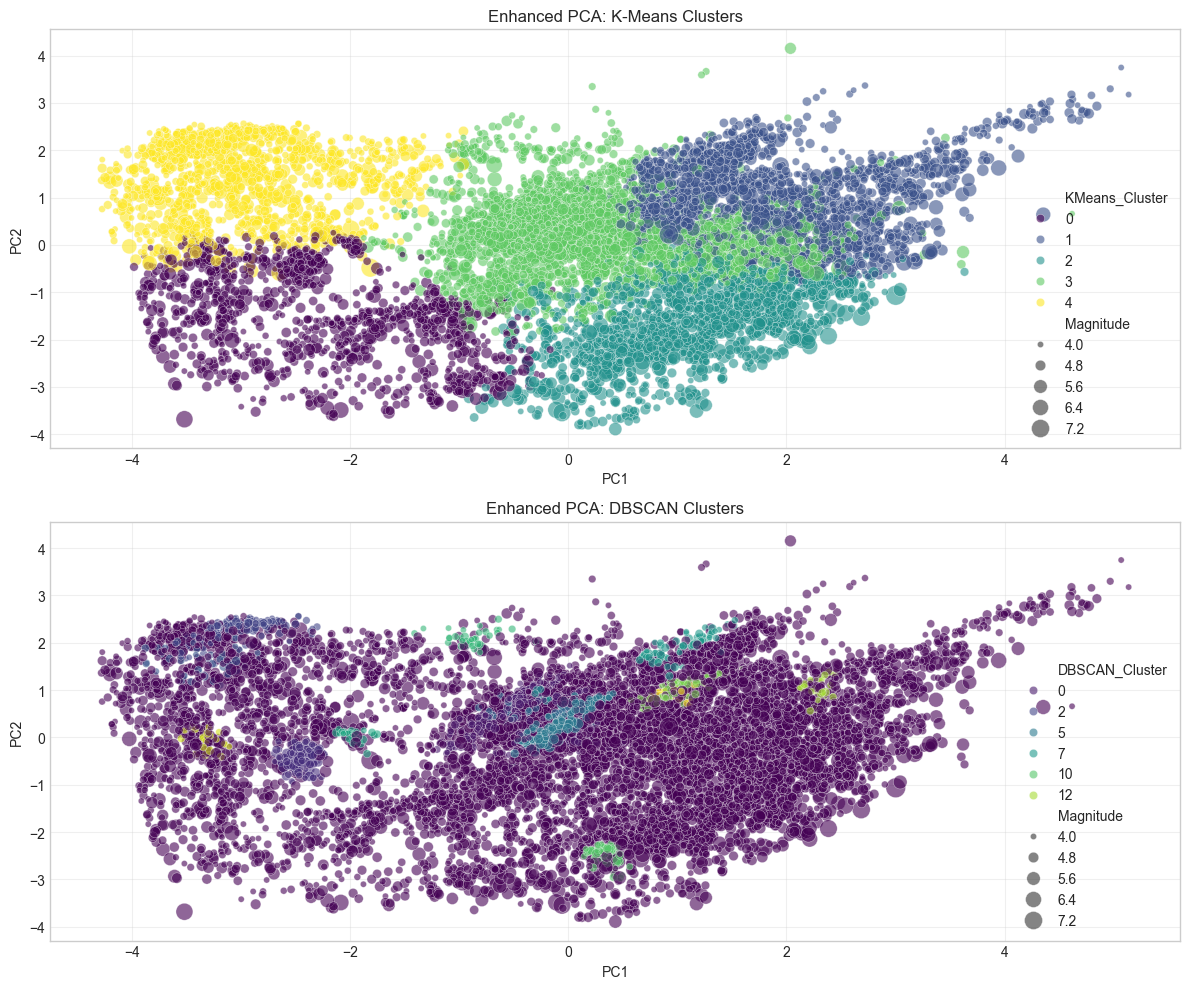


Enhanced PCA Feature Loadings:
                            PC1    PC2
Longitude                 0.341 -0.122
Latitude                  0.361 -0.204
Depth                    -0.205 -0.022
Magnitude                 0.033 -0.098
distance_to_fault        -0.384 -0.325
nearest_fault_importance -0.197 -0.037
weighted_fault_risk       0.407  0.365
fault_complexity_score    0.154  0.148
density_50km             -0.273  0.532
density_100km            -0.324  0.532
fault_count_100km         0.393  0.326


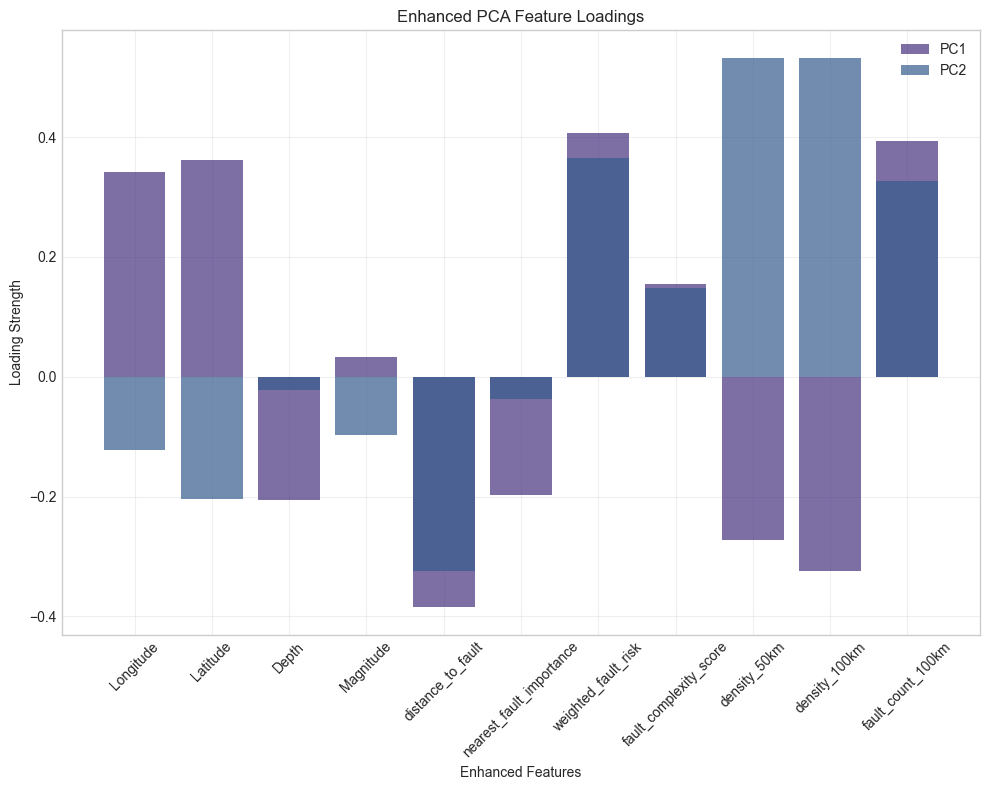

In [9]:
# Enhanced PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Enhanced PCA DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['KMeans_Cluster'] = earthquake_df['KMeans_Cluster']
pca_df['DBSCAN_Cluster'] = earthquake_df['DBSCAN_Cluster']
pca_df['Magnitude'] = earthquake_df['Magnitude']

# Add enhanced features to PCA DataFrame
if 'weighted_fault_risk' in earthquake_df.columns:
    pca_df['weighted_fault_risk'] = earthquake_df['weighted_fault_risk']
    pca_df['fault_complexity_score'] = earthquake_df['fault_complexity_score']
if 'density_50km' in earthquake_df.columns:
    pca_df['density_50km'] = earthquake_df['density_50km']

print("Enhanced PCA explained variance ratio:")
print(pca.explained_variance_ratio_)
print(f"Total explained variance: {sum(pca.explained_variance_ratio_) * 100:.2f}%")

# Enhanced PCA visualizations
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='KMeans_Cluster', palette='viridis', 
                size='Magnitude', sizes=(20, 200), alpha=0.6)
plt.title('Enhanced PCA: K-Means Clusters')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='DBSCAN_Cluster', palette='viridis', 
                size='Magnitude', sizes=(20, 200), alpha=0.6)
plt.title('Enhanced PCA: DBSCAN Clusters')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Enhanced feature loadings
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2'],
    index=clustering_features
)

print("\nEnhanced PCA Feature Loadings:")
print(loadings.round(3))

# Enhanced loading visualization
plt.figure(figsize=(10, 8))
plt.bar(loadings.index, loadings['PC1'], alpha=0.7, label='PC1')
plt.bar(loadings.index, loadings['PC2'], alpha=0.7, label='PC2')
plt.xlabel('Enhanced Features')
plt.ylabel('Loading Strength')
plt.title('Enhanced PCA Feature Loadings')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Enhanced Risk Zone Identification

Developing a comprehensive seismic risk scoring system using clustering results and enhanced geological features. This creates quantitative risk zones for practical earthquake hazard assessment.

**Enhanced Risk Formula:**
- Magnitude impact scoring
- Cluster density weighting
- Multi-fault weighted risk integration
- Geological complexity factors
- Spatial density contributions

Enhanced Risk Zone Distribution:
Risk_Zone
Low       5253
Medium    3963
High       613
Name: count, dtype: int64


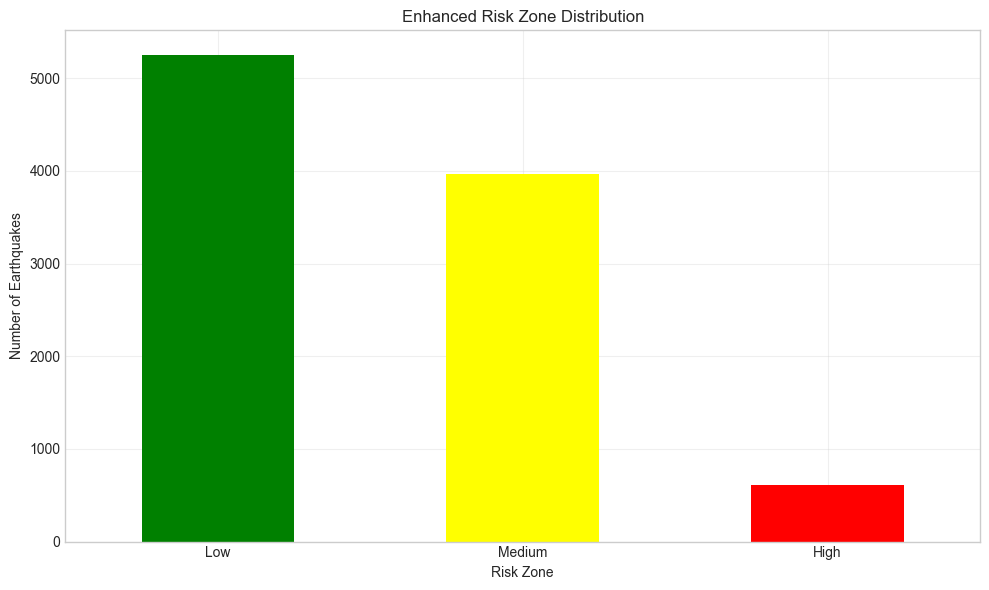


Enhanced risk zone characteristics:
           (Magnitude, mean)  (Magnitude, max)  (Magnitude, count)  \
Risk_Zone                                                            
Low                    4.410               7.1                5253   
Medium                 4.483               7.9                3963   
High                   4.511               7.7                 613   

           (Depth, mean)  (Risk_Score, mean)  (Risk_Score, min)  \
Risk_Zone                                                         
Low               19.609               1.831              0.071   
Medium            19.125               4.068              3.000   
High              31.790               6.819              6.000   

           (Risk_Score, max)  weighted_fault_risk  fault_complexity_score  
Risk_Zone                                                                  
Low                    3.000                7.495                   2.152  
Medium                 5.992               11.76

C:\Users\Sarp Can\AppData\Local\Temp\ipykernel_8376\404079044.py:76: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sarp Can\AppData\Local\Temp\ipykernel_8376\404079044.py:83: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [10]:
# Enhanced risk zone identification using clustering and enhanced features
earthquake_df['Risk_Score'] = 0

# Enhanced magnitude scoring
earthquake_df['Magnitude_Score'] = (earthquake_df['Magnitude'] - 4) * 2.5
earthquake_df['Magnitude_Score'] = earthquake_df['Magnitude_Score'].clip(0, 10)

# Enhanced cluster density calculation
kmeans_spatial_range = earthquake_df.groupby('KMeans_Cluster').agg({
    'Longitude': lambda x: max(x) - min(x),
    'Latitude': lambda x: max(x) - min(x)
})
kmeans_spatial_range = kmeans_spatial_range + 0.001

kmeans_density = earthquake_df.groupby('KMeans_Cluster').size() / kmeans_spatial_range.prod(axis=1)
max_density = kmeans_density.max()
if max_density > 0:
    normalized_density = (kmeans_density / max_density) * 10
else:
    normalized_density = kmeans_density * 0

density_map = dict(zip(normalized_density.index, normalized_density.values))
earthquake_df['Density_Score'] = earthquake_df['KMeans_Cluster'].map(density_map)

# Enhanced risk calculation with new features
if 'weighted_fault_risk' in earthquake_df.columns:
    # Normalize enhanced features to 0-10 scale
    earthquake_df['Normalized_Fault_Risk'] = (earthquake_df['weighted_fault_risk'] / 
                                            earthquake_df['weighted_fault_risk'].max()) * 10
    earthquake_df['Normalized_Complexity'] = (earthquake_df['fault_complexity_score'] / 
                                            earthquake_df['fault_complexity_score'].max()) * 10
    
    # Enhanced risk formula
    earthquake_df['Risk_Score'] = (
        earthquake_df['Magnitude_Score'] * 0.25 + 
        earthquake_df['Density_Score'] * 0.15 +
        earthquake_df['Normalized_Fault_Risk'] * 0.3 +
        earthquake_df['Normalized_Complexity'] * 0.2 +
        (earthquake_df.get('density_50km', 0) * 1000) * 0.1  # Scale spatial density
    )
else:
    # Basic risk calculation if enhanced features unavailable
    fault_distance_score = 10 / (earthquake_df.get('distance_to_fault', 50) + 1)
    fault_importance_score = earthquake_df.get('nearest_fault_importance', 3) * 2
    
    earthquake_df['Risk_Score'] = (
        earthquake_df['Magnitude_Score'] * 0.4 + 
        earthquake_df['Density_Score'] * 0.3 +
        fault_distance_score * 0.2 +
        fault_importance_score * 0.1
    )

# Enhanced risk zone classification
earthquake_df['Risk_Zone'] = pd.cut(
    earthquake_df['Risk_Score'], 
    bins=[0, 3, 6, 10], 
    labels=['Low', 'Medium', 'High']
)

# Enhanced risk analysis
risk_distribution = earthquake_df['Risk_Zone'].value_counts()
print("Enhanced Risk Zone Distribution:")
print(risk_distribution)

plt.figure(figsize=(10, 6))
risk_distribution.plot(kind='bar', color=['green', 'yellow', 'red'])
plt.title('Enhanced Risk Zone Distribution')
plt.xlabel('Risk Zone')
plt.ylabel('Number of Earthquakes')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Enhanced risk statistics by zone
risk_stats = earthquake_df.groupby('Risk_Zone').agg({
    'Magnitude': ['mean', 'max', 'count'],
    'Depth': 'mean',
    'Risk_Score': ['mean', 'min', 'max']
})

if 'weighted_fault_risk' in earthquake_df.columns:
    enhanced_risk_stats = earthquake_df.groupby('Risk_Zone').agg({
        'weighted_fault_risk': 'mean',
        'fault_complexity_score': 'mean'
    })
    risk_stats = pd.concat([risk_stats, enhanced_risk_stats], axis=1)

print("\nEnhanced risk zone characteristics:")
print(risk_stats.round(3))

## Enhanced Risk Zone Mapping

Creating detailed risk zone maps with advanced geological context. These maps combine risk classification with magnitude categorization and comprehensive fault information.

**Map Features:**
- Risk zone color coding (High/Medium/Low)
- Magnitude-based fill colors
- Enhanced popup information
- Comprehensive geological context
- Interactive exploration capabilities

In [11]:
# Enhanced risk zone map with advanced features
risk_map = folium.Map(location=[38.5, 35.5], zoom_start=6, tiles="cartodbpositron")

risk_colors = {
    'Low': 'green',
    'Medium': 'orange', 
    'High': 'red'
}

magnitude_colors = {
    'Minor (4-5)': '#fee5d9',
    'Moderate (5-6)': '#fcbba1',
    'Strong (6-7)': '#fc9272',
    'Major (7-8)': '#fb6a4a',
    'Great (8+)': '#de2d26'
}

# Enhanced marker clusters
marker_clusters = {
    'Low': folium.plugins.MarkerCluster(name='Low Risk').add_to(risk_map),
    'Medium': folium.plugins.MarkerCluster(name='Medium Risk').add_to(risk_map),
    'High': folium.plugins.MarkerCluster(name='High Risk').add_to(risk_map)
}

def get_magnitude_info(magnitude):
    if magnitude >= 8:
        return 'Great (8+)', magnitude_colors['Great (8+)']
    elif magnitude >= 7:
        return 'Major (7-8)', magnitude_colors['Major (7-8)']
    elif magnitude >= 6:
        return 'Strong (6-7)', magnitude_colors['Strong (6-7)']
    elif magnitude >= 5:
        return 'Moderate (5-6)', magnitude_colors['Moderate (5-6)']
    else:
        return 'Minor (4-5)', magnitude_colors['Minor (4-5)']

# Enhanced markers with all features
for idx, row in earthquake_df.iterrows():
    risk_zone = row['Risk_Zone']
    magnitude = row['Magnitude']
    mag_category, mag_color = get_magnitude_info(magnitude)
    
    if magnitude >= 7:
        radius = 15 + ((magnitude - 7) ** 2) * 6
    else:
        radius = 3 + (magnitude - 4) ** 1.5
        
    # Enhanced popup with all new features
    popup_content = f"""
    <div style="font-family: Arial; min-width: 200px;">
        <h4 style="margin-bottom: 5px;">Enhanced Earthquake Risk</h4>
        <b>Magnitude:</b> {magnitude:.1f} ({mag_category})<br>
        <b>Risk Zone:</b> {risk_zone}<br>
        <b>Risk Score:</b> {row['Risk_Score']:.2f}<br>
        <b>Depth:</b> {row['Depth']:.1f} km<br>
    """
    
    if 'Date' in row and pd.notna(row['Date']):
        popup_content += f"<b>Date:</b> {row['Date']}<br>"
    if 'Location' in row and pd.notna(row['Location']):
        popup_content += f"<b>Location:</b> {row['Location']}<br>"
    if 'weighted_fault_risk' in row and pd.notna(row['weighted_fault_risk']):
        popup_content += f"<b>Fault Risk:</b> {row['weighted_fault_risk']:.2f}<br>"
    if 'fault_complexity_score' in row and pd.notna(row['fault_complexity_score']):
        popup_content += f"<b>Complexity:</b> {row['fault_complexity_score']:.2f}<br>"
    if 'density_50km' in row and pd.notna(row['density_50km']):
        popup_content += f"<b>Density (50km):</b> {row['density_50km']:.3f}<br>"
    
    popup_content += "</div>"
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=radius,
        color=risk_colors[risk_zone],
        weight=2,
        fill=True,
        fill_color=mag_color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_content, max_width=350)
    ).add_to(marker_clusters[risk_zone])

risk_map = add_faults_to_map(risk_map, fault_gdf, importance_threshold=3)

# Enhanced legend
risk_legend_html = '''
<div style="position: fixed; bottom: 50px; right: 50px; width: 250px; 
    background-color: white; border:2px solid grey; z-index:9999; 
    padding: 10px; border-radius: 5px; font-family: Arial;">
    <h4 style="margin-top:0;">Enhanced Risk Zones</h4>
    <div style="margin-top:5px;">
      <p><b>Border:</b> Risk Zone</p>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: green; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Low Risk</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: orange; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>Medium Risk</span>
      </div>
      <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="background-color: red; width: 15px; height: 15px; margin-right: 5px; border-radius: 50%;"></div>
        <span>High Risk</span>
      </div>
    </div>
    <div style="margin-top:10px;">
      <p><b>Fill:</b> Magnitude category</p>
      <p><b>Size:</b> Proportional to magnitude</p>
    </div>
    <div style="margin-top:10px;">
      <p><b>Enhanced with:</b> Multi-fault risk, complexity, spatial density</p>
    </div>
</div>
'''
risk_map.get_root().html.add_child(folium.Element(risk_legend_html))

folium.LayerControl().add_to(risk_map)
risk_map.save('maps/enhanced_earthquake_risk_map.html')
print("Enhanced risk map saved")

Enhanced risk map saved


## Enhanced City Risk Assessment

Evaluating earthquake risk for major Turkish cities using enhanced geological features and population data. This provides actionable information for urban planning and emergency preparedness.

**Enhanced City Risk Factors:**
- Multi-fault weighted risk contributions
- Spatial complexity considerations
- Population exposure weighting
- Historical seismic activity patterns
- Enhanced geological context integration

Enhanced City Risk Assessment:
                             city  population  earthquake_count  \
0                        Istanbul    15655924                46   
2                           Izmir     4479525               147   
20                        Sakarya     1100747               173   
3                           Bursa     3214571                85   
11                          Hatay     1544640                88   
17                            Van     1127612               273   
25                        Malatya      742725               267   
16                  Kahramanmaraş     1116618               160   
22                          Muğla     1066736               110   
19                        Denizli     1061043               121   
12                         Manisa     1475716               117   
7                       Gaziantep     2164134                66   
44                       Adıyaman      632000               159   
15                      Balıkes

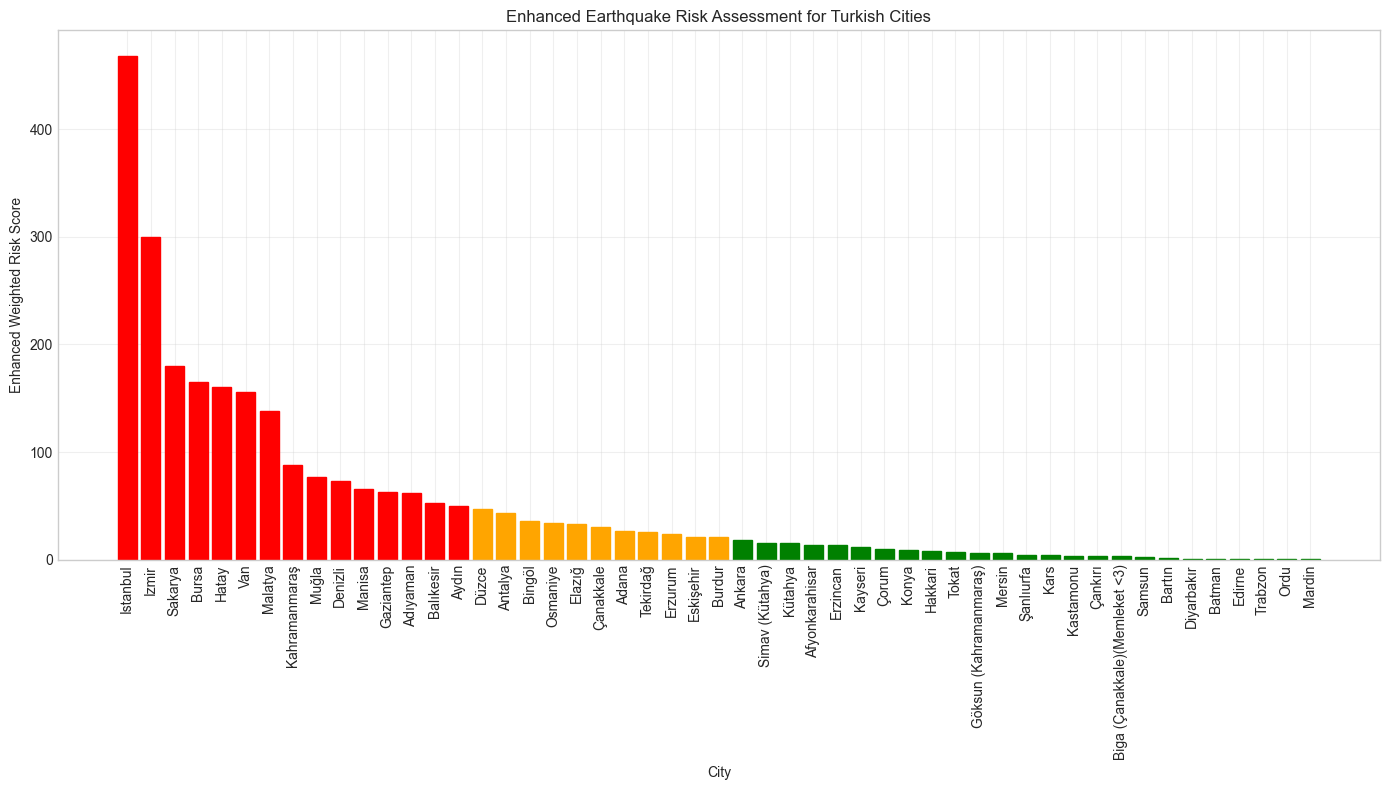

In [12]:
# Enhanced city risk assessment with new features
cities = [
    {"name": "Istanbul", "lat": 41.0082, "lon": 28.9784, "population": 15655924},
    {"name": "Ankara", "lat": 39.9334, "lon": 32.8597, "population": 5803482},
    {"name": "Izmir", "lat": 38.4237, "lon": 27.1428, "population": 4479525},
    {"name": "Bursa", "lat": 40.1885, "lon": 29.0610, "population": 3214571},
    {"name": "Antalya", "lat": 36.8969, "lon": 30.7133, "population": 2696249},
    {"name": "Adana", "lat": 37.0000, "lon": 35.3213, "population": 2270298},
    {"name": "Konya", "lat": 37.8667, "lon": 32.4833, "population": 2320241},
    {"name": "Gaziantep", "lat": 37.0662, "lon": 37.3833, "population": 2164134},
    {"name": "Şanlıurfa", "lat": 37.1591, "lon": 38.7969, "population": 2213964},
    {"name": "Mersin", "lat": 36.8000, "lon": 34.6333, "population": 1938389},
    {"name": "Diyarbakır", "lat": 37.9144, "lon": 40.2306, "population": 1818133},
    {"name": "Hatay", "lat": 36.2025, "lon": 36.1606, "population": 1544640},
    {"name": "Manisa", "lat": 38.6191, "lon": 27.4289, "population": 1475716},
    {"name": "Kayseri", "lat": 38.7205, "lon": 35.4826, "population": 1445683},
    {"name": "Samsun", "lat": 41.2867, "lon": 36.3300, "population": 1377546},
    {"name": "Balıkesir", "lat": 39.6484, "lon": 27.8826, "population": 1273519},
    {"name": "Kahramanmaraş", "lat": 37.5750, "lon": 36.9228, "population": 1116618},
    {"name": "Van", "lat": 38.4942, "lon": 43.3800, "population": 1127612},
    {"name": "Aydın", "lat": 37.8444, "lon": 27.8458, "population": 1161702},
    {"name": "Denizli", "lat": 37.7765, "lon": 29.0864, "population": 1061043},
    {"name": "Sakarya", "lat": 40.7731, "lon": 30.3943, "population": 1100747},
    {"name": "Tekirdağ", "lat": 40.9833, "lon": 27.5167, "population": 1167059},
    {"name": "Muğla", "lat": 37.2153, "lon": 28.3636, "population": 1066736},
    {"name": "Eskişehir", "lat": 39.7767, "lon": 30.5206, "population": 915418},
    {"name": "Mardin", "lat": 37.3212, "lon": 40.7245, "population": 888874},
    {"name": "Malatya", "lat": 38.3552, "lon": 38.3095, "population": 742725},
    {"name": "Trabzon", "lat": 41.0053, "lon": 39.7267, "population": 824352},
    {"name": "Erzurum", "lat": 39.9042, "lon": 41.2705, "population": 749993},
    {"name": "Ordu", "lat": 40.9839, "lon": 37.8764, "population": 775800},
    {"name": "Afyonkarahisar", "lat": 38.7587, "lon": 30.5387, "population": 751344},
    {"name": "Çanakkale", "lat": 40.1553, "lon": 26.4142, "population": 570499},
    {"name": "Düzce", "lat": 40.8438, "lon": 31.1565, "population": 409865},
    {"name": "Bingöl", "lat": 38.8855, "lon": 40.4983, "population": 285655},
    {"name": "Tokat", "lat": 40.3167, "lon": 36.5500, "population": 606934},
    {"name": "Kütahya", "lat": 39.4167, "lon": 29.9833, "population": 575671},
    {"name": "Batman", "lat": 37.8812, "lon": 41.1351, "population": 647205},
    {"name": "Elazığ", "lat": 38.6748, "lon": 39.2225, "population": 604411},
    {"name": "Çorum", "lat": 40.5489, "lon": 34.9533, "population": 528351},
    {"name": "Biga (Çanakkale)(Memleket <3)", "lat": 40.2322, "lon": 27.2464, "population": 87000},
    {"name": "Simav (Kütahya)", "lat": 39.0922, "lon": 28.9789, "population": 64000},
    {"name": "Göksun (Kahramanmaraş)", "lat": 38.0203, "lon": 36.4825, "population": 31000},
    {"name": "Kastamonu", "lat": 41.3887, "lon": 33.7827, "population": 383000},
    {"name": "Burdur", "lat": 37.7215, "lon": 30.2886, "population": 270000},
    {"name": "Kars", "lat": 40.6013, "lon": 43.0950, "population": 289000},
    {"name": "Adıyaman", "lat": 37.7636, "lon": 38.2773, "population": 632000},
    {"name": "Çankırı", "lat": 40.6013, "lon": 33.6134, "population": 195000},
    {"name": "Edirne", "lat": 41.6771, "lon": 26.5557, "population": 411000},
    {"name": "Bartın", "lat": 41.6358, "lon": 32.3375, "population": 198000},
    {"name": "Erzincan", "lat": 39.75, "lon": 39.49, "population": 234000},
    {"name": "Hakkari", "lat": 37.57, "lon": 43.74, "population": 267000},
    {"name": "Osmaniye", "lat": 37.0746, "lon": 36.2464, "population": 534000}
]

def calculate_enhanced_city_risk(city, earthquake_df, radius_km=50):
    """Enhanced city risk calculation with new features"""
    def haversine(lon1, lat1, lon2, lat2):
        lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a))
        return c * 6371
    
    nearby_earthquakes = []
    for idx, quake in earthquake_df.iterrows():
        distance = haversine(city["lon"], city["lat"], quake["Longitude"], quake["Latitude"])
        if distance <= radius_km:
            nearby_earthquakes.append({
                "distance": distance,
                "magnitude": quake["Magnitude"],
                "risk_score": quake.get("Risk_Score", 0),
                "weighted_fault_risk": quake.get("weighted_fault_risk", 0),
                "fault_complexity": quake.get("fault_complexity_score", 0),
                "spatial_density": quake.get("density_50km", 0)
            })
    
    if not nearby_earthquakes:
        return {
            "city": city["name"], "population": city["population"],
            "lat": city["lat"], "lon": city["lon"],
            "earthquake_count": 0, "weighted_risk": 0, "risk_category": "Low"
        }
    
    # Enhanced risk calculation
    weighted_risks = []
    for quake in nearby_earthquakes:
        weight = quake["magnitude"] * (1 / (quake["distance"] + 1))
        
        # Add enhanced feature weights
        if quake["weighted_fault_risk"] > 0:
            weight *= (1 + quake["weighted_fault_risk"] / 10)
        if quake["fault_complexity"] > 0:
            weight *= (1 + quake["fault_complexity"] / 20)
        if quake["spatial_density"] > 0:
            weight *= (1 + quake["spatial_density"] * 10)
            
        weighted_risks.append(weight)
    
    weighted_risk = sum(weighted_risks) * (city["population"] / 1000000)
    
    risk_category = "High" if weighted_risk > 50 else "Medium" if weighted_risk > 20 else "Low"
    
    return {
        "city": city["name"], "population": city["population"],
        "lat": city["lat"], "lon": city["lon"],
        "earthquake_count": len(nearby_earthquakes),
        "avg_magnitude": sum(q["magnitude"] for q in nearby_earthquakes) / len(nearby_earthquakes),
        "max_magnitude": max(q["magnitude"] for q in nearby_earthquakes),
        "weighted_risk": weighted_risk, "risk_category": risk_category
    }

# Calculate enhanced risk for each city
city_risks = [calculate_enhanced_city_risk(city, earthquake_df) for city in cities]
city_risk_df = pd.DataFrame(city_risks).sort_values("weighted_risk", ascending=False)

print("Enhanced City Risk Assessment:")
print(city_risk_df[["city", "population", "earthquake_count", "weighted_risk", "risk_category"]])

# Enhanced visualization
plt.figure(figsize=(14, 8))
bars = plt.bar(city_risk_df["city"], city_risk_df["weighted_risk"])

for i, bar in enumerate(bars):
    color = {"High": "red", "Medium": "orange", "Low": "green"}[city_risk_df.iloc[i]["risk_category"]]
    bar.set_color(color)

plt.xticks(rotation=90)
plt.xlabel("City")
plt.ylabel("Enhanced Weighted Risk Score")
plt.title("Enhanced Earthquake Risk Assessment for Turkish Cities")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Enhanced City Risk Visualization

Creating interactive city risk maps that combine seismic hazard assessment with population vulnerability. These visualizations support evidence-based emergency planning and resource allocation.

**Visualization Components:**
- City risk categorization and ranking
- Population-weighted risk markers
- Enhanced earthquake density overlay
- Comprehensive risk information display

In [ ]:
# Enhanced city risk map visualization
city_risk_map = folium.Map(location=[38.5, 35.5], zoom_start=6)
city_risk_map = add_faults_to_map(city_risk_map, fault_gdf, importance_threshold=3)

# Enhanced city markers
for _, city_data in city_risk_df.iterrows():
    city_info = next((c for c in cities if c["name"] == city_data["city"]), None)
    if not city_info:
        continue
    
    color = {"High": "red", "Medium": "orange", "Low": "green"}[city_data["risk_category"]]
    radius = 5 + (city_data["weighted_risk"] / 10)
    
    # Enhanced popup with all metrics
    popup_content = f"""
    <div style="font-family: Arial; min-width: 250px;">
        <h4 style="margin-bottom: 5px; color: #1976d2; border-bottom: 1px solid #ddd; padding-bottom: 5px;">
            {city_data['city']}
        </h4>
        <div style="margin-top: 8px;">
            <b>Population:</b> {city_data['population']:,}<br>
            <b>Risk Category:</b> <span style="color: {color}; font-weight: bold;">{city_data['risk_category']}</span><br>
            <b>Enhanced Risk Score:</b> {city_data['weighted_risk']:.2f}<br>
            <hr style="margin: 8px 0; border-top: 1px dotted #ddd;">
            <b>Earthquake Statistics:</b><br>
            <span style="margin-left: 10px;">Nearby Earthquakes: {city_data['earthquake_count']}</span><br>
            <span style="margin-left: 10px;">Average Magnitude: {city_data['avg_magnitude']:.2f}</span><br>
            <span style="margin-left: 10px;">Maximum Magnitude: {city_data['max_magnitude']:.2f}</span><br>
        </div>
    </div>
    """
    
    folium.CircleMarker(
        location=[city_info["lat"], city_info["lon"]],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_content, max_width=350)
    ).add_to(city_risk_map)

# Enhanced heatmap layer
heat_data = [[row['Latitude'], row['Longitude'], row.get('weighted_fault_risk', 1)] 
             for _, row in earthquake_df.iterrows()]
HeatMap(heat_data, radius=10, blur=15, 
        gradient={'0.4': 'blue', '0.6': 'cyan', '0.8': 'yellow', '1.0': 'red'}, 
        name="Enhanced Risk Density").add_to(city_risk_map)

folium.LayerControl().add_to(city_risk_map)
city_risk_map.save('maps/enhanced_city_earthquake_risk_map.html')
print("Enhanced city risk map saved")

Enhanced city risk map saved


## Enhanced Analysis Summary and Export

Summarizing our comprehensive earthquake pattern analysis and exporting enhanced datasets for future use. This provides a complete picture of Turkey's seismic landscape.

**Final Deliverables:**
- Enhanced cluster and risk zone analysis
- Comprehensive city risk assessments
- Interactive risk visualization maps
- Export of enhanced analytical datasets
- Performance metrics and insights

**Key Findings:**
- Identification of distinct earthquake zones
- Quantitative city risk rankings
- Enhanced geological risk factors
- Comprehensive risk visualization system

C:\Users\Sarp Can\AppData\Local\Temp\ipykernel_8376\2384926990.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sarp Can\AppData\Local\Temp\ipykernel_8376\2384926990.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Sarp Can\AppData\Local\Temp\ipykernel_8376\2384926990.py:21: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Enhanced Cluster and Risk Zone Summary:
                          (Magnitude, mean)  (Magnitude, min)  \
KMeans_Cluster Risk_Zone                                        
0              Low                    4.409               4.0   
               Medium                 4.445               4.0   
               High                     NaN               NaN   
1              Low                    4.342               4.0   
               Medium                 4.475               4.0   
               High                   5.191               4.1   
2              Low                    4.513               4.0   
               Medium                 6.479               5.2   
               High                     NaN               NaN   
3              Low                    4.337               4.0   
               Medium                 4.524               4.0   
               High                   5.950               4.7   
4              Low                      NaN       

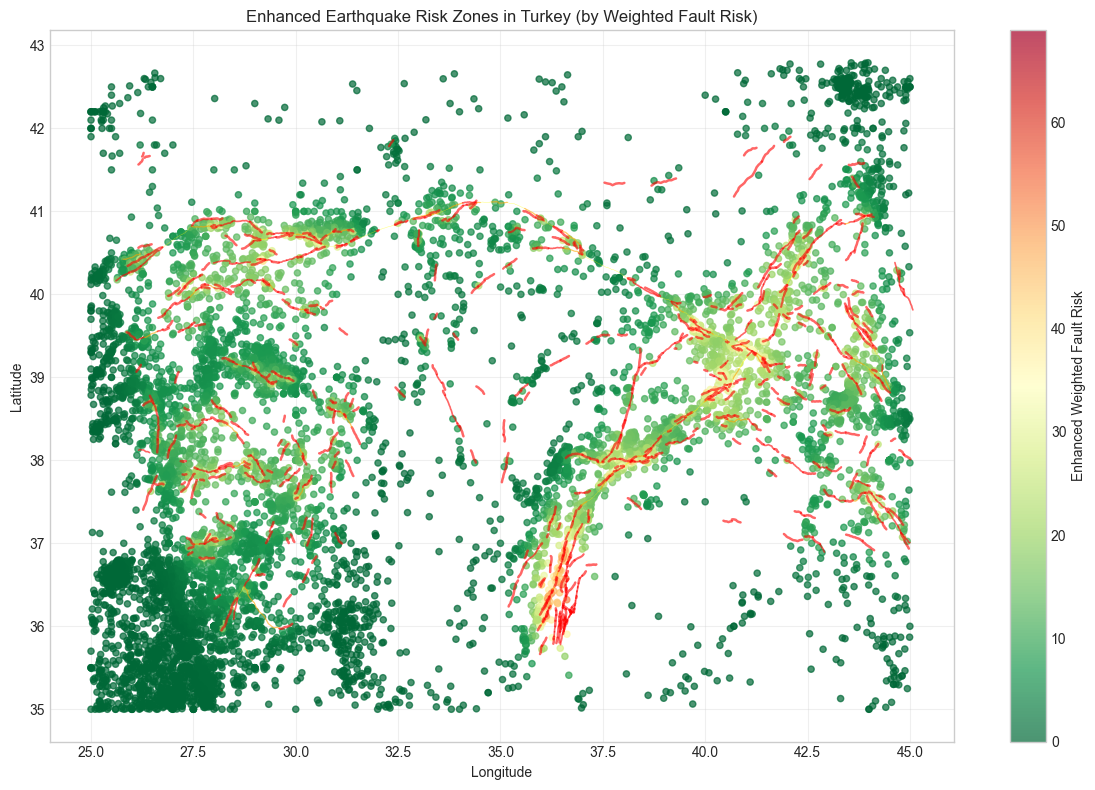


Enhanced Analysis Completed!
Total earthquakes analyzed: 9829
Features used for clustering: 11
K-Means clusters identified: 5
DBSCAN clusters identified: 15
High-risk earthquakes: 613
Cities assessed: 51
High-risk cities: 15
Enhanced datasets exported to produced_data/


In [14]:
# Enhanced analysis summary and final export
earthquake_df.to_csv('produced_data/enhanced_earthquake_clusters.csv', index=False)

# Enhanced cluster and risk zone summary
cluster_risk_summary = earthquake_df.groupby(['KMeans_Cluster', 'Risk_Zone']).agg({
    'Magnitude': ['mean', 'min', 'max', 'count'],
    'Depth': ['mean', 'min', 'max'],
    'Risk_Score': ['mean', 'min', 'max']
})

# Enhanced features summary
enhanced_summary = {}
if 'weighted_fault_risk' in earthquake_df.columns:
    enhanced_features = earthquake_df.groupby(['KMeans_Cluster', 'Risk_Zone']).agg({
        'weighted_fault_risk': ['mean', 'max'],
        'fault_complexity_score': ['mean', 'max']
    })
    cluster_risk_summary = pd.concat([cluster_risk_summary, enhanced_features], axis=1)

if 'density_50km' in earthquake_df.columns:
    density_summary = earthquake_df.groupby(['KMeans_Cluster', 'Risk_Zone']).agg({
        'density_50km': 'mean',
        'density_100km': 'mean'
    })
    cluster_risk_summary = pd.concat([cluster_risk_summary, density_summary], axis=1)

print("Enhanced Cluster and Risk Zone Summary:")
print(cluster_risk_summary.round(3))

# Enhanced final visualization: Risk zones by location with enhanced features
plt.figure(figsize=(12, 8))
if 'weighted_fault_risk' in earthquake_df.columns:
    scatter = plt.scatter(
        earthquake_df['Longitude'], earthquake_df['Latitude'],
        c=earthquake_df['weighted_fault_risk'],
        cmap='RdYlGn_r', alpha=0.7, s=20
    )
    plt.colorbar(scatter, label='Enhanced Weighted Fault Risk')
    plt.title('Enhanced Earthquake Risk Zones in Turkey (by Weighted Fault Risk)')
else:
    scatter = plt.scatter(
        earthquake_df['Longitude'], earthquake_df['Latitude'],
        c=earthquake_df['Risk_Score'],
        cmap='RdYlGn_r', alpha=0.7, s=20
    )
    plt.colorbar(scatter, label='Risk Score')
    plt.title('Enhanced Earthquake Risk Zones in Turkey')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)

# Enhanced fault overlay
if 'fault_gdf' in locals():
    for _, fault in fault_gdf.iterrows():
        if hasattr(fault.geometry, 'xy'):
            xs, ys = fault.geometry.xy
            importance = fault.get('importance', 1)
            color = 'red' if importance >= 4 else 'orange' if importance >= 3 else 'yellow'
            plt.plot(xs, ys, color=color, linewidth=importance*0.3, alpha=0.6)

plt.tight_layout()
plt.savefig('maps/enhanced_earthquake_risk_zones.png', dpi=300)
plt.show()

# Enhanced performance metrics
print(f"\nEnhanced Analysis Completed!")
print(f"Total earthquakes analyzed: {len(earthquake_df)}")
print(f"Features used for clustering: {len(clustering_features)}")
print(f"K-Means clusters identified: {len(earthquake_df['KMeans_Cluster'].unique())}")
print(f"DBSCAN clusters identified: {len(set(earthquake_df['DBSCAN_Cluster'])) - (1 if -1 in earthquake_df['DBSCAN_Cluster'].values else 0)}")
print(f"High-risk earthquakes: {len(earthquake_df[earthquake_df['Risk_Zone'] == 'High'])}")
print(f"Cities assessed: {len(city_risk_df)}")
print(f"High-risk cities: {len(city_risk_df[city_risk_df['risk_category'] == 'High'])}")

# Export enhanced city risk data
city_risk_df.to_csv('produced_data/enhanced_city_risk_assessment.csv', index=False)
print("Enhanced datasets exported to produced_data/")